In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
from scipy.spatial import distance
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from nctpy.utils import matrix_normalization

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'MICS'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

In [3]:
adjacency = np.load(os.path.join(indir, '{0}_{1}_Am.npy'.format(which_data, atlas)))
adjacency_norm = matrix_normalization(adjacency, system='continuous')

In [4]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
parc_centroids.drop(columns=['ROI Label'], inplace=True)
print(parc_centroids.head())

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [5]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

if which_data == 'HCPYA':
    n_states = 7
elif which_data == 'MICS':
    n_states = 5

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()

control_energy_static_decay = log_args['control_energy_static_decay']
control_energy_variable_decay = log_args['control_energy_variable_decay']

print(log_args.keys())
print(control_energy_static_decay.shape, control_energy_variable_decay.shape)

HCPYA-Schaefer4007-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2
dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay'])
(7, 7) (7, 7)


# Training

In [6]:
log_args['loss'].shape

(7, 7, 1000)

In [7]:
log_args['optimized_weights'].shape

(7, 7, 1000, 400)

In [8]:
eigen_vals_max = np.zeros((n_states, n_states, n_steps))
eigen_vals_var = np.zeros((n_states, n_states, n_steps))
eigen_vals_max[:] = np.nan
eigen_vals_var[:] = np.nan

for i in tqdm(np.arange(n_states)):
    for j in np.arange(n_states):
        try:
            idx = np.where(np.isnan(log_args['loss'][i, j]))[0][0] - 1
        except:
            idx = n_steps - 1

        for k in np.arange(idx):
            adjacency_sub = adjacency_norm - np.diag(log_args['optimized_weights'][i, j][k, :])
            eig = np.linalg.eigvalsh(adjacency_sub)
            eigen_vals_max[i, j, k] = np.max(eig)
            eigen_vals_var[i, j, k] = np.var(eig)

100%|██████████| 7/7 [01:29<00:00, 12.81s/it]


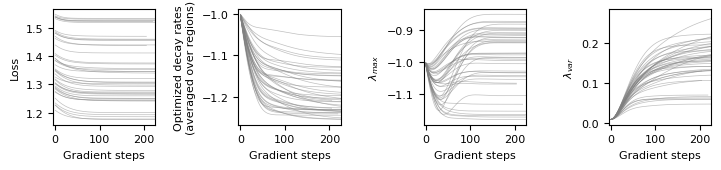

In [9]:
f, ax = plt.subplots(1, 4, figsize=(7.25, 1.75))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        if i != j:
            ax[0].plot(log_args['loss'][i, j], c='gray', alpha=0.5, linewidth=0.5)
            x = -log_args['optimized_weights'][i, j]
            ax[1].plot(x.mean(axis=1), c='gray', alpha=0.5, linewidth=0.5)
            ax[2].plot(eigen_vals_max[i, j], c='gray', alpha=0.5, linewidth=0.5)
            ax[3].plot(eigen_vals_var[i, j], c='gray', alpha=0.5, linewidth=0.5)
            
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Optimized decay rates\n(averaged over regions)')
ax[2].set_ylabel('$\lambda_{max}$')
ax[3].set_ylabel('$\lambda_{var}$')

for this_ax in ax:
    this_ax.set_xlabel('Gradient steps')
    this_ax.set_xlim([-5, 225])

f.tight_layout()
f.savefig(os.path.join(outdir, 'training.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()